In [1]:
from pyspark.sql import SparkSession
from pyspark.sql import SQLContext
from pyspark.sql.functions import when
from pyspark.sql.functions import col
from pyspark.sql.types import * 
from pyspark.sql.functions import lit
import pyodbc
import pandas as pd
import pyspark.sql.functions as sf
from pyspark.context import SparkContext


In [2]:
import findspark
findspark.init()


In [3]:
spark = SparkSession.builder.config("spark.driver.memory", "15g").getOrCreate()

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


22/12/24 00:46:23 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [4]:
def process_log_data(path,file_name,date):
    df = spark.read.json(path+file_name)
    df = df.select('_source.AppName','_source.Contract','_source.Mac','_source.TotalDuration')
    df = df.withColumn('Date',lit(date))
    df = df.withColumn('Type',
                 when((col("AppName") == 'CHANNEL') | (col("AppName") =='DSHD')| (col("AppName") =='KPLUS')| (col("AppName") =='KPlus'), "Dramas")
          .when((col("AppName") == 'VOD') | (col("AppName") =='FIMS_RES')| (col("AppName") =='BHD_RES')| 
                 (col("AppName") =='VOD_RES')| (col("AppName") =='FIMS')| (col("AppName") =='BHD')| (col("AppName") =='DANET'), "TV Shows")
          .when((col("AppName") == 'RELAX'), "Entertainment")
          .when((col("AppName") == 'CHILD'), "Kids")
          .when((col("AppName") == 'SPORT'), "Sports")
          .otherwise("Error"))
    df = df.select('Contract','Type','TotalDuration','Date')
    df = df.groupBy('Contract','Type','Date').agg({'TotalDuration':'sum'}).withColumnRenamed('sum(TotalDuration)','TotalDuration')
    return df 

In [5]:
def main_task():
    path="/Users/quynhnguyen/Documents/DA classes/Big Data/Dataset/"
    df = process_log_data(path,"20220401.json",'2022-04-01')
    for i in range(2,31):
        day = ("{:02d}".format(i))
        filename = '202204{}.json'.format(day)
        date = '2022-04-{}'.format(day)
        df1 = process_log_data(path,filename, date)
        df = df.union(df1)
    return df

In [17]:
df = main_task() 
df = df.cache()
df.count()

22/12/24 01:51:54 WARN CacheManager: Asked to cache already cached data.


42010590

In [18]:
df.show()

+---------+--------+----------+-------------+
| Contract|    Type|      Date|TotalDuration|
+---------+--------+----------+-------------+
|TGFD20318|  Dramas|2022-04-01|        84056|
|BNFD55622|  Dramas|2022-04-01|         4968|
|TVAAA0290|TV Shows|2022-04-01|         4153|
|NTD035685|TV Shows|2022-04-01|            0|
|HNH815050|TV Shows|2022-04-01|        15684|
|TQFD01800|  Dramas|2022-04-01|        89152|
|THFD12339|TV Shows|2022-04-01|        82473|
|CTFD22053|TV Shows|2022-04-01|        20990|
|VPFD10186|TV Shows|2022-04-01|         2953|
|HNH385936|  Dramas|2022-04-01|        18885|
|SGH043105|TV Shows|2022-04-01|        10273|
|HDFD45530|  Dramas|2022-04-01|        82435|
|HNH411694|  Dramas|2022-04-01|        54048|
|HNH921243|TV Shows|2022-04-01|         4436|
|SGH918630|  Dramas|2022-04-01|           38|
|SGD406054|TV Shows|2022-04-01|        10107|
|SLFD02698|  Dramas|2022-04-01|       131614|
|HNH003269|TV Shows|2022-04-01|         9486|
|SGH955709|TV Shows|2022-04-01|   

In [19]:
df.select('Date').distinct().count()

30

In [20]:
df.filter(df.TotalDuration.isNull()).show() ##Check if any null variables

+--------+-----+----------+-------------+
|Contract| Type|      Date|TotalDuration|
+--------+-----+----------+-------------+
|    null|Error|2022-04-08|         null|
+--------+-----+----------+-------------+



In [21]:
df.filter(df.Contract.isNull()).show() ##Check if any null variables

+--------+-----+----------+-------------+
|Contract| Type|      Date|TotalDuration|
+--------+-----+----------+-------------+
|    null|Error|2022-04-08|         null|
+--------+-----+----------+-------------+



In [26]:
df = df.dropna(how="any")
df.show(truncate=False)

+---------+--------+----------+-------------+
|Contract |Type    |Date      |TotalDuration|
+---------+--------+----------+-------------+
|TGFD20318|Dramas  |2022-04-01|84056        |
|BNFD55622|Dramas  |2022-04-01|4968         |
|TVAAA0290|TV Shows|2022-04-01|4153         |
|NTD035685|TV Shows|2022-04-01|0            |
|HNH815050|TV Shows|2022-04-01|15684        |
|TQFD01800|Dramas  |2022-04-01|89152        |
|THFD12339|TV Shows|2022-04-01|82473        |
|CTFD22053|TV Shows|2022-04-01|20990        |
|VPFD10186|TV Shows|2022-04-01|2953         |
|HNH385936|Dramas  |2022-04-01|18885        |
|SGH043105|TV Shows|2022-04-01|10273        |
|HDFD45530|Dramas  |2022-04-01|82435        |
|HNH411694|Dramas  |2022-04-01|54048        |
|HNH921243|TV Shows|2022-04-01|4436         |
|SGH918630|Dramas  |2022-04-01|38           |
|SGD406054|TV Shows|2022-04-01|10107        |
|SLFD02698|Dramas  |2022-04-01|131614       |
|HNH003269|TV Shows|2022-04-01|9486         |
|SGH955709|TV Shows|2022-04-01|137

In [27]:
df.filter(df.Contract.isNull()).show()

+--------+----+----+-------------+
|Contract|Type|Date|TotalDuration|
+--------+----+----+-------------+
+--------+----+----+-------------+



In [28]:
daily_statistic = df.groupBy('Date','Type').agg({'TotalDuration':'sum','Contract':'count'}).withColumnRenamed('sum(TotalDuration)','TotalDuration').withColumnRenamed('count(Contract)','TotalUsers')

In [30]:
daily_statistic.show()

+----------+-------------+----------+-------------+
|      Date|         Type|TotalUsers|TotalDuration|
+----------+-------------+----------+-------------+
|2022-04-01|       Sports|      2292|      1166238|
|2022-04-02|Entertainment|     14183|     23660631|
|2022-04-03|       Sports|      2601|      2089684|
|2022-04-03|         Kids|     35671|    213572505|
|2022-04-03|     TV Shows|     88953|    669111655|
|2022-04-04|         Kids|     31857|    191329814|
|2022-04-04|       Dramas|   1330592|  25023515316|
|2022-04-04|       Sports|      2386|      1270644|
|2022-04-05|         Kids|     31864|    186712205|
|2022-04-05|       Dramas|   1320852|  24446474511|
|2022-04-07|Entertainment|      5325|     17691561|
|2022-04-07|         Kids|     31254|    177306488|
|2022-04-07|       Dramas|   1319626|  24649587137|
|2022-04-08|       Dramas|     65718|   1910030687|
|2022-04-10|Entertainment|      6130|     23014479|
|2022-04-10|       Sports|      2898|      1815888|
|2022-04-10|

In [31]:
daily_statistic = daily_statistic.withColumn('TotalDuration',col('TotalDuration')/3600)
daily_statistic.show()

+----------+-------------+----------+------------------+
|      Date|         Type|TotalUsers|     TotalDuration|
+----------+-------------+----------+------------------+
|2022-04-01|       Sports|      2292|           323.955|
|2022-04-02|Entertainment|     14183|         6572.3975|
|2022-04-03|       Sports|      2601| 580.4677777777778|
|2022-04-03|         Kids|     35671| 59325.69583333333|
|2022-04-03|     TV Shows|     88953| 185864.3486111111|
|2022-04-04|         Kids|     31857| 53147.17055555555|
|2022-04-04|       Dramas|   1330592| 6950976.476666667|
|2022-04-04|       Sports|      2386|352.95666666666665|
|2022-04-05|         Kids|     31864|51864.501388888886|
|2022-04-05|       Dramas|   1320852| 6790687.364166667|
|2022-04-07|Entertainment|      5325|         4914.3225|
|2022-04-07|         Kids|     31254| 49251.80222222222|
|2022-04-07|       Dramas|   1319626| 6847107.538055556|
|2022-04-08|       Dramas|     65718| 530564.0797222222|
|2022-04-10|Entertainment|     

In [32]:
df.repartition(1).write.csv('/Users/quynhnguyen/Documents/DA classes/Big Data/Dataset/DF_Clean',header=True)

In [33]:
daily_statistic.repartition(1).write.csv('/Users/quynhnguyen/Documents/DA classes/Big Data/Dataset/Daily_Statistic',header=True)

## Descriptive Statistic daily

In [34]:
visual_1 = daily_statistic.toPandas()

In [35]:
visual_1 = visual_1.sort_values(by = 'Date', ascending = True)

In [40]:
visual_1.head()

,Date,Type,TotalUsers,TotalDuration
0,2022-04-01,Sports,2292,3.239550e+02
54,2022-04-01,Dramas,1355367,7.002872e+06
55,2022-04-01,Kids,33056,4.960283e+04
53,2022-04-01,TV Shows,86312,1.742085e+05
52,2022-04-01,Entertainment,6394,5.807752e+03


In [37]:
import matplotlib.pyplot as plt
import seaborn as sns

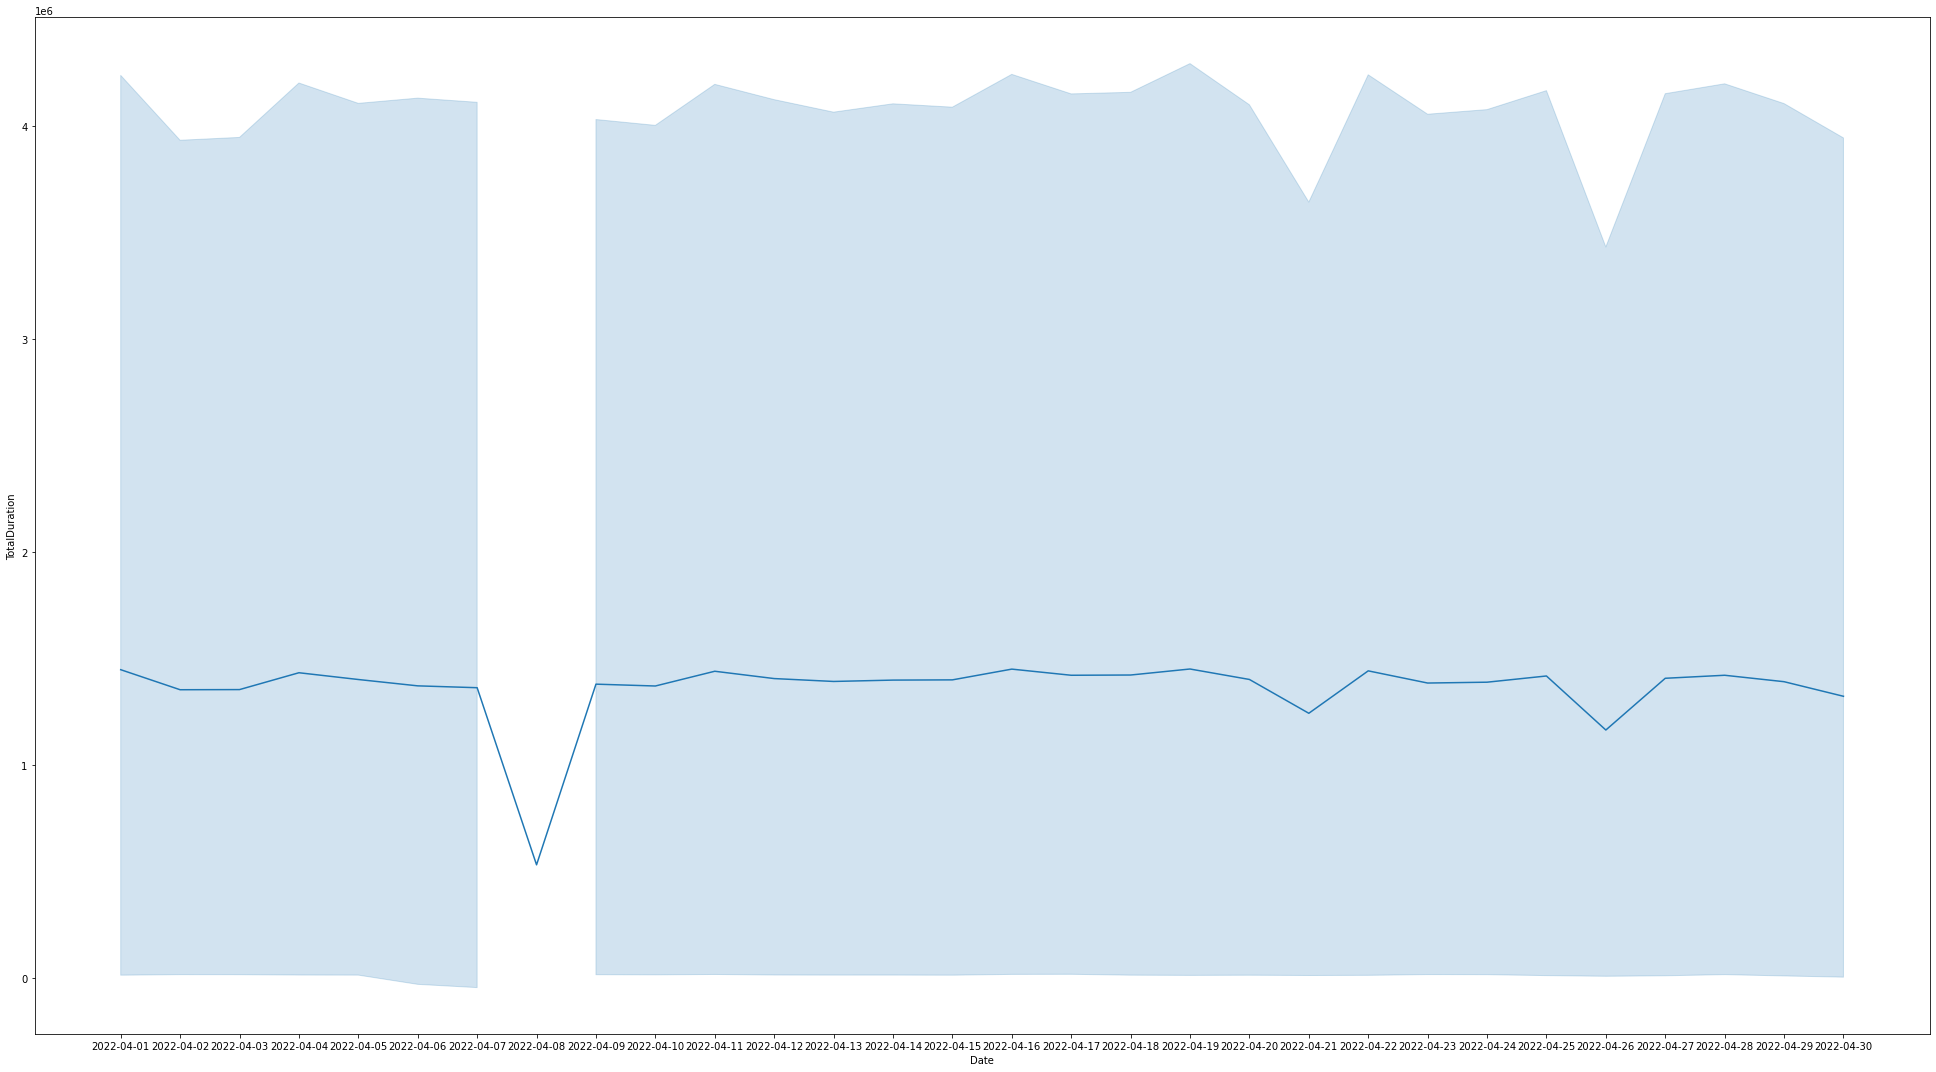

In [38]:
plt.figure(figsize=(27, 15))
sns.lineplot(x = 'Date', y ='TotalDuration', data = visual_1)
plt.tight_layout()

<AxesSubplot:xlabel='Date', ylabel='TotalDuration'>

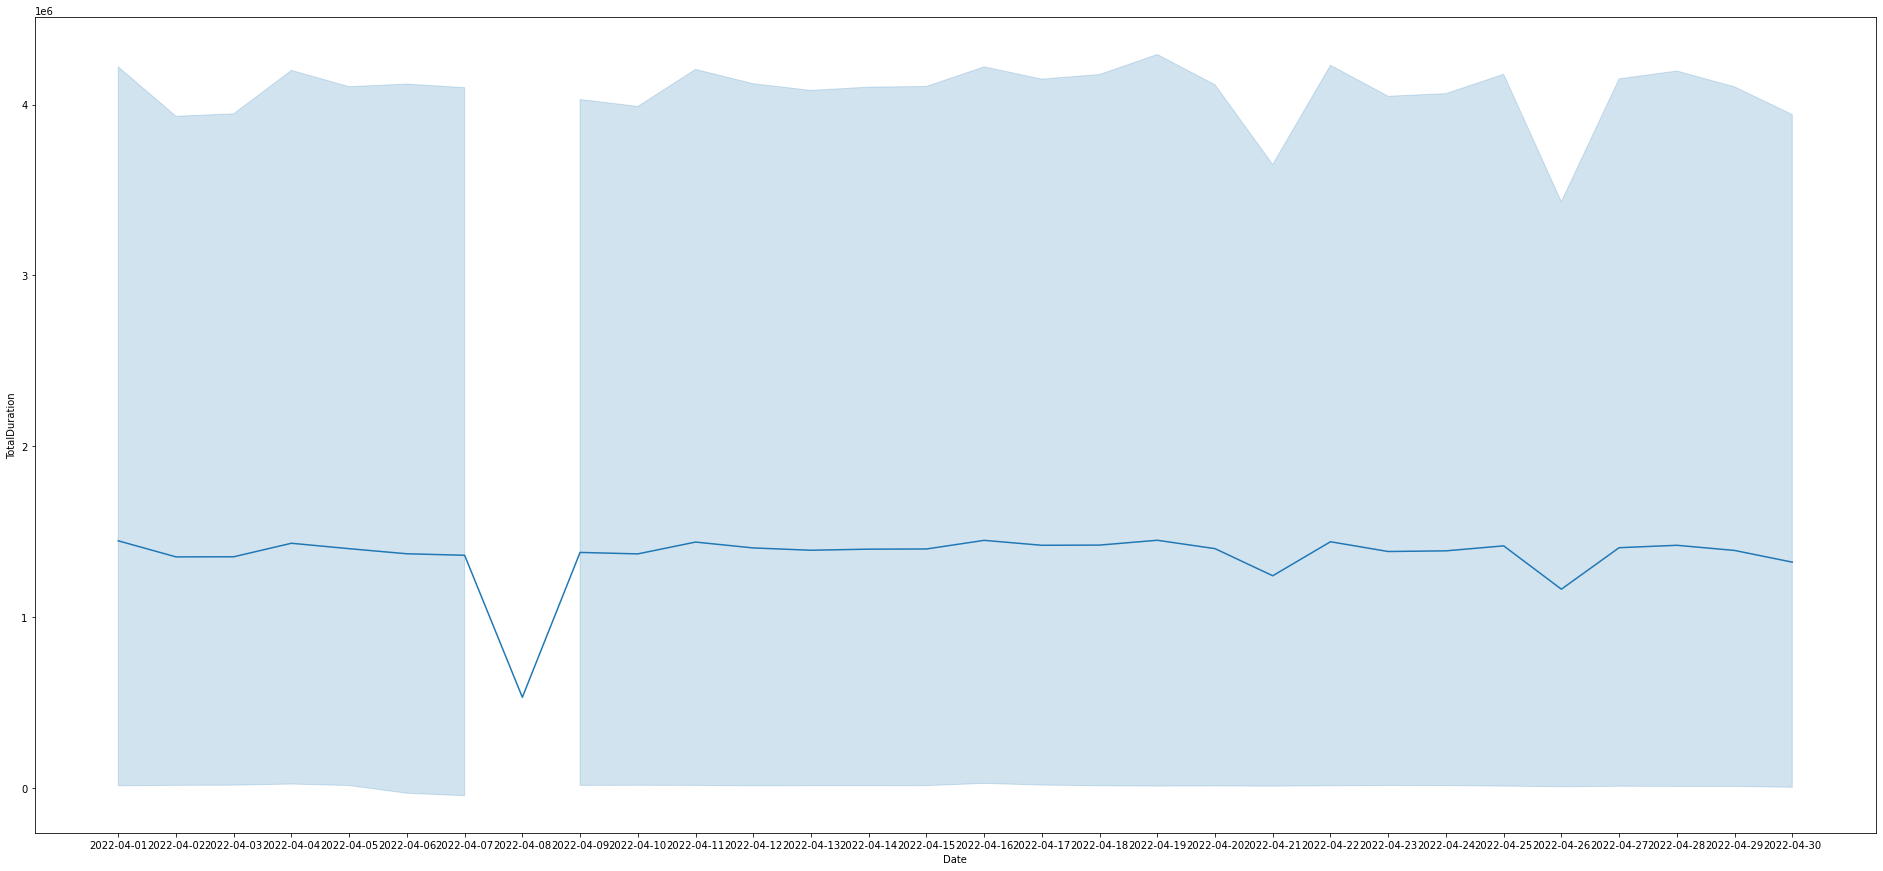

In [39]:
plt.figure(figsize=(33, 15))
sns.lineplot(data = visual_1 , x = 'Date' , y ='TotalDuration')

In [41]:
df.count()

42010589

In [43]:
df.select('Contract').count()

42010589

In [44]:
df.select('Contract').distinct().count()

1918176

## Individual Customer Statistics

In [45]:
df.printSchema()

root
 |-- Contract: string (nullable = true)
 |-- Type: string (nullable = false)
 |-- Date: string (nullable = false)
 |-- TotalDuration: long (nullable = true)



In [46]:
df = df.drop('Date')

In [47]:
df = df.groupBy('Contract','Type').agg({'TotalDuration':'sum'}).withColumnRenamed('sum(TotalDuration)','TotalDuration')

In [48]:
df.show()